## Data Loader

In [1]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / (float(window[0, col_i]) + 0.00000001) ) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)


## Get configs

In [2]:
import json
import os

configs = json.load(open('config.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])
pre_trained_model_filepath = configs['model']['pre_trained']

dataloader = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)
x_train, y_train = dataloader.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
)

In [3]:
x_train[0:100].shape

(100, 29, 1)

In [4]:
columns = configs['data']['columns']
seq_len = configs['data']['sequence_length']

## Agent

In [24]:
### MODEL HYPERPARAMETERS
# Here our possible actions
sit = [1, 0, 0]
buy = [0, 1, 0]
sell = [0, 0, 1]
possible_actions = [sit, buy, sell]
state_size = (seq_len -1, len(columns))      # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels) 
action_size = 3              # 3 possible actions: sit, buy, sell
learning_rate =  0.0002      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 10       # Total episodes for training
max_steps = 1000              # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.001            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate


### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [25]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
import random
from collections import deque

In [26]:
class Agent:
    def __init__(self, state_size, action_size, learning_rate, gamma=0.95, 
                 explore_start=1.0, explore_stop=0.01, decay_rate=0.00007, possible_actions = [], name='Agent', 
                 is_eval=False):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=1000)
        
        self.gamma = gamma
        
        self.explore_start = explore_start
        self.explore_stop = explore_stop
        self.decay_rate = decay_rate
        self.decay_step = 0
        self.explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * self.decay_step)
        
        self.possible_actions = possible_actions
        
        self.model = load_model("models/" + model_name) if is_eval else self._model()
        
        self.loss = 9999
        
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_shape=state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Flatten())
#         model.add(Dense(units=32, activation="relu"))
#         model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="softmax"))
        model.compile(loss="mse", optimizer=Adam(lr=learning_rate))
        model.summary()
        return model
    
    def predict_point_by_point(self, data):
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted
    
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
                
            target_f = self.model.predict(state)
            target_f[0][action] = target
            hist = self.model.fit(state, target_f, epochs=1, verbose=0)
            self.loss = hist.history['loss'].pop()
            
        if self.explore_probability > self.explore_stop:
            self.explore_probability = self.explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
            
    def predict_action(self, state):
        ## EPSILON GREEDY STRATEGY
        # Choose action a from state s using epsilon greedy.
        ## First we randomize a number
        exp_exp_tradeoff = np.random.rand()

        # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
        self.explore_probability = self.explore_stop + (self.explore_start - self.explore_stop) * np.exp(-self.decay_rate * self.decay_step)

#         print("comparar ", self.explore_probability > exp_exp_tradeoff, self.explore_probability, exp_exp_tradeoff)
        if (self.explore_probability > exp_exp_tradeoff):
            # Make a random action (exploration)
            action = np.argmax(random.choice(self.possible_actions))
    #         print("random ", action)
        else:
            predicted = self.predict_point_by_point(state)
    #         print("array predicted ", predicted)
            action = np.argmax(predicted)
    #         print("predicted ", action)

        self.decay_step += 1

        return action, self.explore_probability

In [27]:
DQNetwork = Agent(state_size, action_size, learning_rate, gamma, possible_actions=possible_actions, decay_rate=decay_rate)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 29, 64)            128       
_________________________________________________________________
dense_10 (Dense)             (None, 29, 32)            2080      
_________________________________________________________________
dense_11 (Dense)             (None, 29, 8)             264       
_________________________________________________________________
flatten_3 (Flatten)          (None, 232)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 699       
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________


## Train

In [28]:
data = x_train[0:200]
def next_state(index=0):
    return data[index:index+1]

In [29]:
# Initialize the decay rate (that will use to reduce epsilon) 
decay_step = 0

#  Set step to 0
step = 0

cash = 10_000
first_price = dataloader.data_train[0][0]

total_profit = 0
position = 0
last_transaction = 0

# Initialize the rewards of the episode
episode_rewards = []
rewards = []

debug = False

state = next_state()

In [30]:
def make_action(state, action, last_transaction=0, total_profit=0, 
                position=0, first_price=0):
    close = state[0][-1][0]
    not_do_anything_reward = 0
    if(action == 0): 
        return not_do_anything_reward, last_transaction, total_profit, position
    if (action == 1 and position == 0):
        position = 1
        last_transaction = (1.0 + close) * first_price
        if debug: print("Buy: $", '%.2f' % last_transaction)
        return not_do_anything_reward, last_transaction, total_profit, position
    if(action == 2 and position == 1):
        position = 0
        price_now = (1.0 + close) * first_price
        profit = price_now - last_transaction
        profit_per = (price_now / last_transaction - 1.0) * 100
        total_profit += profit
        if debug: print("Sell: $", '%.2f' % price_now, 
                        " - Profit $", '%.2f' % profit, 
                        " - ", '%.2f' % profit_per, "%" )
        return profit, last_transaction, total_profit, position
    return not_do_anything_reward, last_transaction, total_profit, position

In [31]:
for i in range(0, total_episodes):
    print("Episode #", i + 1)
    step = 0
    episode_rewards = []
    my_reward = 0

    while step < len(data) - seq_len:
        step += 1
#         if debug: print("Step: ", step)

        # Increase decay_step
        decay_step +=1

        # Predict the action to take and take it
        action, explore_probability = DQNetwork.predict_action(state)

        # Do the action
        reward, last_transaction, total_profit, position = make_action(
            state, action, last_transaction, total_profit, position, first_price)

        # Add the reward to total reward of the episode
        episode_rewards.append(reward)
        
        # Add to memory 
        next_st = next_state(step)
        done = True if step >= len(data) - seq_len else False
        DQNetwork.memory.append((state, action, reward, next_st, done))
        
        state = next_st
        
        my_reward +=reward
        
        print("Step ", step, " of ", len(data) - seq_len,
               " - Loss:", '%.4f' % DQNetwork.loss, " - Reward ", '%.4f' %  my_reward, end="\r")
        
        # Learning         
        if len(DQNetwork.memory) > batch_size:
            DQNetwork.expReplay(batch_size)
        

        # If done
        if done:            
            total_reward = np.sum(episode_rewards)
            rewards.append(total_reward)
            DQNetwork.model.save("saved_models/model_ep" + str(i))

            print('Episode: {}'.format(i + 1),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(DQNetwork.loss),
                      'Explore P: {:.4f}'.format(explore_probability))

Episode # 1
Episode: 1 Total reward: -179.67799890924562 Training loss: 0.0716 Explore P: 0.8461
Episode # 2
Episode: 2 Total reward: -175.26321342498431 Training loss: 0.0111 Explore P: 0.7154
Episode # 3
Episode: 3 Total reward: 143.97706143051687 Training loss: 0.0947 Explore P: 0.6051
Episode # 4
Episode: 4 Total reward: 60.3103119937598 Training loss: 1672.3691 Explore P: 0.5121
Episode # 5
Episode: 5 Total reward: 90.79908547024502 Training loss: 0.2742 Explore P: 0.4336
Episode # 6
Episode: 6 Total reward: 71.39233839427447 Training loss: 431.2334 Explore P: 0.3673
Episode # 7
Episode: 7 Total reward: 273.4584437634039 Training loss: 0.1256 Explore P: 0.3115
Episode # 8
Episode: 8 Total reward: 112.46551121952507 Training loss: 0.0058 Explore P: 0.2643
Episode # 9
Episode: 9 Total reward: 169.97833266861676 Training loss: 0.1225 Explore P: 0.2246
Episode # 10
Episode: 10 Total reward: 115.9514152814861 Training loss: 0.0412 Explore P: 0.1910


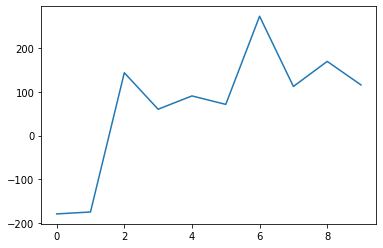

In [33]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

# Evaluate


In [34]:
x_test, y_test = dataloader.get_test_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)
data = x_test[0:100]

In [35]:
debug = True

In [36]:
step = 0
episode_rewards = []
my_reward = 0

while step < len(data) - seq_len:
    step += 1
    if debug: print("Step: ", step)

    # Predict the action to take and take it
    action, explore_probability = DQNetwork.predict_action(state)

    # Do the action
    reward, last_transaction, total_profit, position = make_action(
        state, action, last_transaction, total_profit, position, first_price)

    # Add the reward to total reward of the episode
    episode_rewards.append(reward)

    # Add to memory 
    next_st = next_state(step)
    done = True if step >= len(data) - seq_len else False
    DQNetwork.memory.append((state, action, reward, next_st, done))

    state = next_st

    my_reward +=reward

    print("Step ", step, " of ", len(data) - seq_len,
           " - Loss:", '%.4f' % DQNetwork.loss, " - Reward ", '%.4f' %  my_reward, end="\r")

    # Learning         
#     if len(DQNetwork.memory) > batch_size:
#         DQNetwork.expReplay(batch_size)


    # If done
    if done:            
        total_reward = np.sum(episode_rewards)
        rewards.append(total_reward)
        DQNetwork.model.save("saved_models/model_ep" + str(i))

        print('Episode: {}'.format(i + 1),
                  'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(DQNetwork.loss),
                  'Explore P: {:.4f}'.format(explore_probability))

Step:  1
Step:  2
Step:  3
Sell: $ 1482.70  - Profit $ 40.77  -  2.83 %
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9
Step:  10
Step:  11
Step:  12
Step:  13
Step:  14
Step:  15
Step:  16
Step:  17
Step:  18
Step:  19
Step:  20
Step:  21
Step:  22
Buy: $ 1493.19
Step:  23
Sell: $ 1494.71  - Profit $ 1.52  -  0.10 %
Step:  24
Step:  25
Step:  26
Step:  27
Step:  28
Step:  29
Step:  30
Step:  31
Step:  32
Step:  33
Step:  34
Step:  35
Step:  36
Step:  37
Step:  38
Buy: $ 1472.29
Step:  39
Sell: $ 1483.25  - Profit $ 10.96  -  0.74 %
Step:  40
Step:  41
Step:  42
Step:  43
Step:  44
Step:  45
Step:  46
Step:  47
Step:  48
Step:  49
Step:  50
Step:  51
Step:  52
Step:  53
Step:  54
Step:  55
Step:  56
Step:  57
Step:  58
Step:  59
Step:  60
Step:  61
Step:  62
Step:  63
Step:  64
Step:  65
Step:  66
Step:  67
Step:  68
Step:  69
Step:  70
Episode: 10 Total reward: 53.24274174132029 Training loss: 0.0412 Explore P: 0.1788
